# Far Field Refraction Diagnostic

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_6/'
lam = 0.796
# All length units are in um

The spatial specrum of the beam gives the angular distribution of the rays in the beam. A pure Bessel beam is a thin ring in k-space. Any refracted beams should show up as a characteristic intensity pattern depending on how much refraction occurs. In this notebook I look at how this refraction signal shows up in the output of the LO_6 Optic.

In [2]:
r = np.load(path+'r.npy')
E = np.load(path+'e.npy')
plasma = np.load(path+'plasma.npy')

# These don't do anything since load=True
Nx = 2**8
X = 40e3
tau = 30
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : True,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
    'name' : 'Refracted_Beam',
}
pulse = laserpulse.Pulse(pulseParams)

In [3]:
def get_k_space(ind, ind_t):
    e0 = pulse.load_field(ind)[0]
    e = np.zeros((pulse.Nx, pulse.Ny), dtype='complex128')
    e[:, :] = pulse.reconstruct_from_cyl(pulse.x, e0[ind_t, :], pulse.x, pulse.y)
    k_xy = pulse.fft(e[:, :])
    k_xy = fftshift(k_xy)
    k = (pulse.Nx-1)/pulse.X/2
    ext = [-k, k, -k, k]
    return k, k_xy, ext

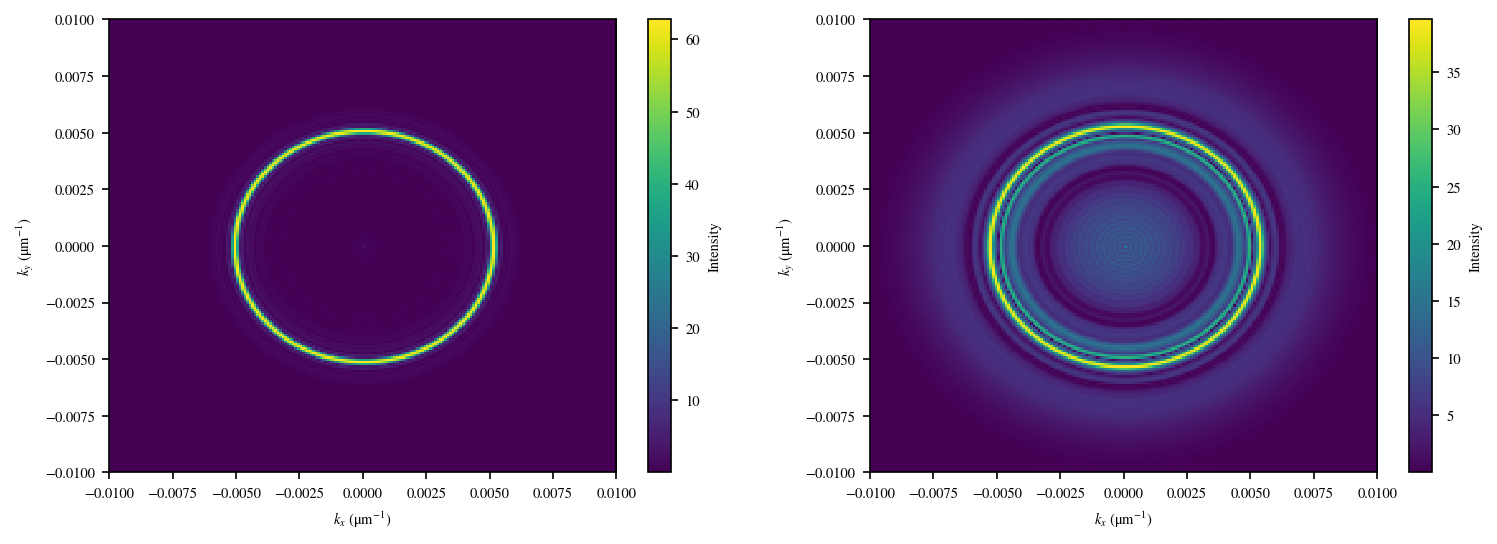

In [4]:
ind_t = int(pulse.Nt/2)+10
k, k_xy0, ext = get_k_space(0, ind_t)
k, k_xy, ext = get_k_space(399, ind_t)
lim = [-0.01, 0.01]

plt.figure(figsize=(12, 4), dpi=150)
plt.subplot(121)
plt.imshow(abs(k_xy0)/pulse.Nx, aspect='auto', extent=ext)
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.xlabel(r'$k_x$ ($\mathrm{\mu m^{-1}}$)')
plt.ylabel(r'$k_y$ ($\mathrm{\mu m^{-1}}$)')
plt.xlim(lim)
plt.ylim(lim)

plt.subplot(122)
plt.imshow(abs(k_xy)/pulse.Nx, aspect='auto', extent=ext)
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.xlabel(r'$k_x$ ($\mathrm{\mu m^{-1}}$)')
plt.ylabel(r'$k_y$ ($\mathrm{\mu m^{-1}}$)')
plt.xlim(lim)
plt.ylim(lim)
plt.show()

In [5]:
def get_full_k_space(ind):
    I = np.zeros((pulse.Nt, pulse.Nx, pulse.Ny))
    for i in range(pulse.Nt):
        k, k_xy, ext = get_k_space(ind, i)
        I[i, :, :] = abs(k_xy[:, :])**2
    return I

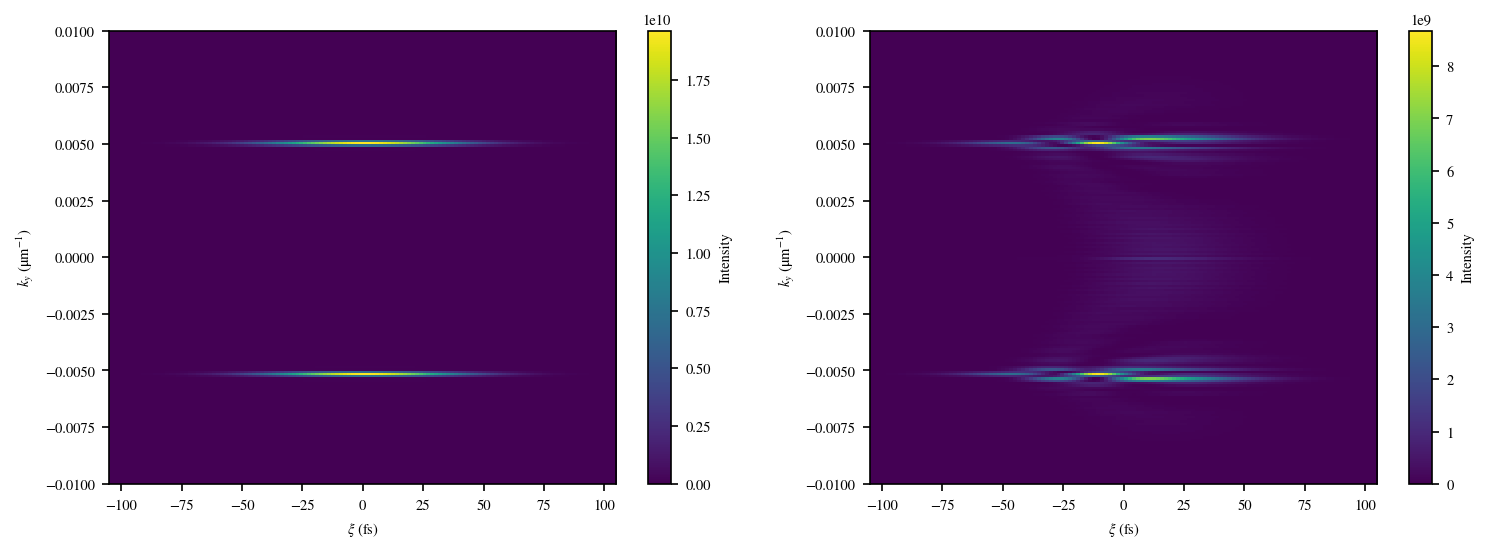

In [6]:
I_0 = get_full_k_space(0)
I = get_full_k_space(399)
ext_t = [-pulse.T/2, pulse.T/2, ext[2], ext[3]]

plt.figure(figsize=(12, 4), dpi=150)
plt.subplot(121)
plt.imshow(np.transpose(I_0[:, :, int(pulse.Ny/2)]), aspect='auto', extent=ext_t)
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.xlabel(r'$\xi$ (fs)')
plt.ylabel(r'$k_y$ ($\mathrm{\mu m^{-1}}$)')
plt.ylim(lim)

plt.subplot(122)
plt.imshow(np.transpose(I[:, :, int(pulse.Ny/2)]), aspect='auto', extent=ext_t)
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.xlabel(r'$\xi$ (fs)')
plt.ylabel(r'$k_y$ ($\mathrm{\mu m^{-1}}$)')
plt.ylim(lim)
plt.show()

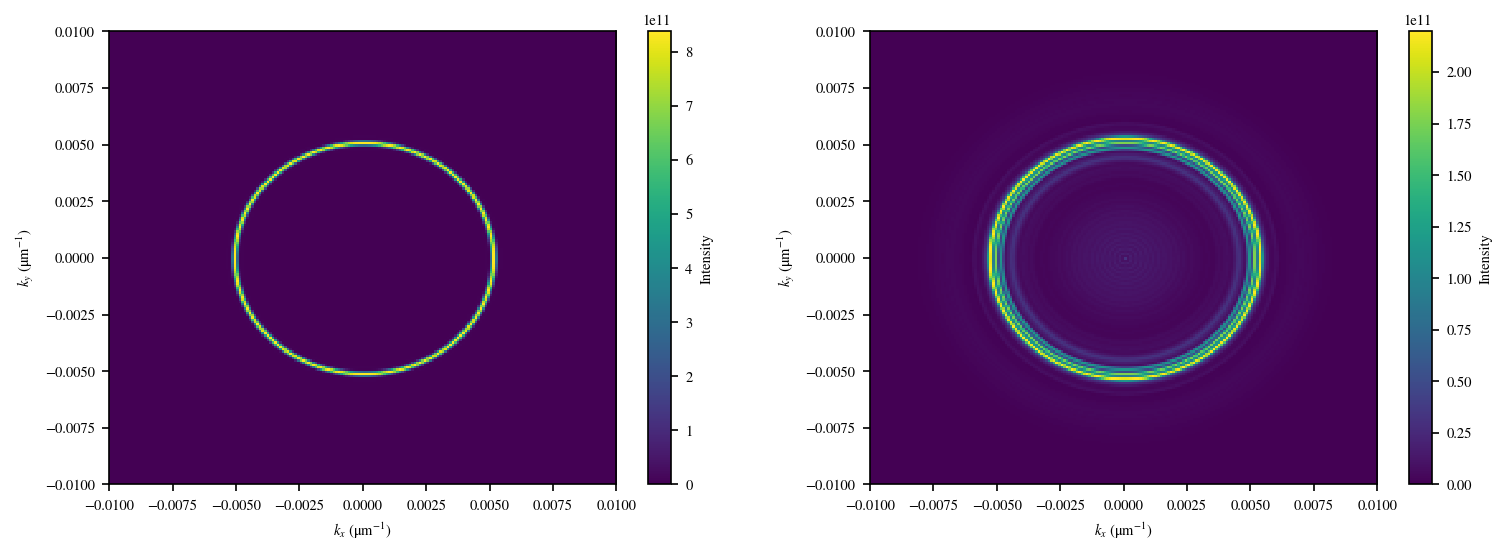

In [7]:
I_0t = np.sum(I_0, axis=0)
I_t = np.sum(I, axis=0)

plt.figure(figsize=(12, 4), dpi=150)
plt.subplot(121)
plt.imshow(I_0t, aspect='auto', extent=ext)
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.xlabel(r'$k_x$ ($\mathrm{\mu m^{-1}}$)')
plt.ylabel(r'$k_y$ ($\mathrm{\mu m^{-1}}$)')
plt.xlim(lim)
plt.ylim(lim)

plt.subplot(122)
plt.imshow(I_t, aspect='auto', extent=ext)
cb = plt.colorbar()
cb.set_label(r'Intensity')
plt.set_cmap('viridis')
plt.xlabel(r'$k_x$ ($\mathrm{\mu m^{-1}}$)')
plt.ylabel(r'$k_y$ ($\mathrm{\mu m^{-1}}$)')
plt.xlim(lim)
plt.ylim(lim)
plt.show()

The measurable signal of refraction is the time integrated intensity in k space. Since this signal should be spherically symmetric, a line out of the intensity represents the measurable signal.

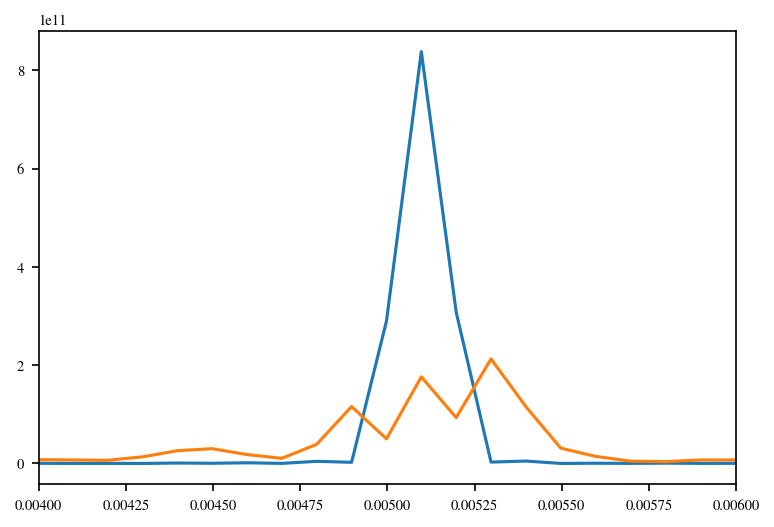

In [9]:
k_a = np.linspace(-k, k, pulse.Nx, endpoint=False)

plt.figure(figsize=(6, 4), dpi=150)
plt.plot(k_a, I_0t[:, int(pulse.Ny/2)])
plt.plot(k_a, I_t[:, int(pulse.Ny/2)])
plt.xlim(0.004, 0.006)
plt.show()